In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt

2025-06-04 15:04:53.992003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 15:04:53.994884: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 15:04:54.002115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749042294.013833 2475761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749042294.017240 2475761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749042294.027128 2475761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [111]:
def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 2  # Number of standard deviation sigma
    xmax = max(
        abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta))
    )
    xmax = np.ceil(max(1, xmax))
    ymax = max(
        abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta))
    )
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(
        -0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)
    ) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [112]:
gb = gabor(sigma=2.0, theta=0, Lambda=3.0, psi=0.5, gamma=1 )

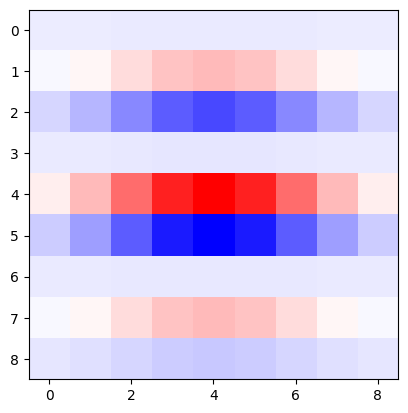

In [113]:
plt.imshow(gb, cmap='bwr')

In [29]:
def gabor_kernel(size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated by 0°, 30°, 60°, 90°, 120°, 150°
angles = np.deg2rad(np.arange(0, 180, 30))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [15]:
filters.shape

(7, 7, 1, 6)

In [ ]:
filters[:,:,0,1]

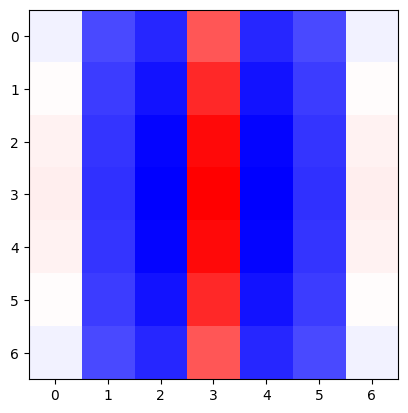

In [30]:
plt.imshow(filters[:,:,0,3], cmap='bwr')

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [24]:
gabor_data = []
for pic in x_train:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

In [25]:
gabor_data = np.array(gabor_data)

In [26]:
gabor_data.shape

(60000, 10, 10, 6)

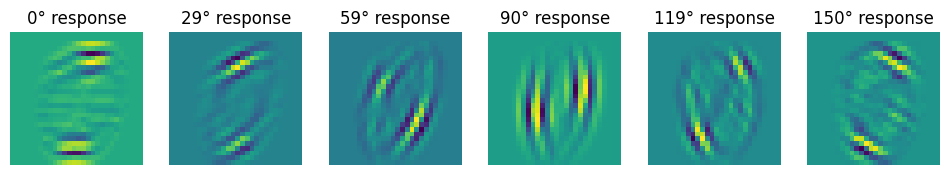

In [7]:
plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(gabor_data[1000,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [9]:
test = np.expand_dims(x_train[5], axis=0)

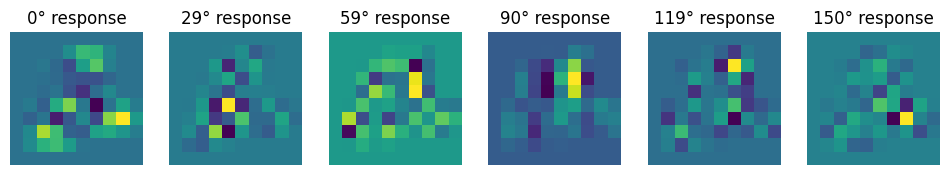

In [22]:
feature_maps = tf.nn.conv2d(test, filters, strides=3, padding='SAME')

plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [23]:
feature_maps.shape

TensorShape([1, 10, 10, 6])

In [27]:
import pickle
path = "/home/yaning/Documents/"

with open(path + "gabor_data_10.pkl", "wb") as f:
    pickle.dump(gabor_data, f)